In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
print(torch.cuda.is_available())
device = 'cuda'

True


In [3]:
transform = transforms.ToTensor()

training = datasets.MNIST('./data', train=True, download=True, transform=transform)
testing = datasets.MNIST('./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.80MB/s]


In [4]:
from torch.utils.data import random_split

train_set, dev_set = random_split(training, [50000, 10000])

In [5]:
training_loader = DataLoader(train_set, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=32)
testing_loader = DataLoader(testing, batch_size=32)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout=0.0):
        super().__init__()
        self.layers = [input_size] + hidden_layers + [output_size]
        self.network_layers = nn.ModuleList()
        self.relu = nn.ReLU()
        self.dropout_prob = dropout
        self.dropout = nn.Dropout(self.dropout_prob)

        for i in range(len(self.layers)-1):
            self.network_layers.append(nn.Linear(self.layers[i], self.layers[i+1]))

    def forward(self, x):
        for i in range(len(self.network_layers)-1): # all layers except output
            x = self.network_layers[i](x)
            x = self.relu(x)
            x = self.dropout(x)

        #output
        x = self.network_layers[-1](x)
        return x

In [7]:
net = NeuralNetwork(784, [256, 64], 10, dropout=0.3).cuda()
print(net.layers)

[784, 256, 64, 10]


In [8]:
def dataset_accuracy(model, loader):
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        for X, y in loader:

            X = X.reshape(-1, 784).cuda()
            y = y.cuda()

            output = model(X)
            correct_predictions += torch.sum(torch.max(output, 1)[1] == y).item()
        model.train()
        return correct_predictions / len(loader.dataset)

In [11]:
import torch.optim

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001, weight_decay=0.06)


epochs = 20
for epoch in range(epochs):

    epoch_loss = 0
    correct_predictions = 0

    for X, y in training_loader:

        X = X.reshape(-1, 784).cuda()
        y = y.cuda()

        optimizer.zero_grad()
        output = net(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct_predictions += torch.sum(torch.max(output, dim=1)[1] == y).item()

    loss_score = epoch_loss/len(training_loader)
    training_accuracy = correct_predictions/len(training_loader.dataset)
    dev_accuracy = dataset_accuracy(net, dev_loader)

    print(f"epoch: {epoch+1}  loss = {loss_score}, training accuracy = {training_accuracy}, dev accuracy = {dev_accuracy}")

print('------------------')
print(f'Test set accuracy = {dataset_accuracy(net, testing_loader)}')

epoch: 1  loss = 0.037747671601258026, training accuracy = 0.98876, dev accuracy = 0.9841
epoch: 2  loss = 0.03264594688317104, training accuracy = 0.99, dev accuracy = 0.9845
epoch: 3  loss = 0.028891764696594654, training accuracy = 0.991, dev accuracy = 0.9838
epoch: 4  loss = 0.02606213885966196, training accuracy = 0.9918, dev accuracy = 0.9839
epoch: 5  loss = 0.026307206960186878, training accuracy = 0.99204, dev accuracy = 0.985
epoch: 6  loss = 0.025050437242550235, training accuracy = 0.99236, dev accuracy = 0.9842
epoch: 7  loss = 0.025701041952694955, training accuracy = 0.99214, dev accuracy = 0.984
epoch: 8  loss = 0.02243776036504929, training accuracy = 0.99336, dev accuracy = 0.984
epoch: 9  loss = 0.023016465382467044, training accuracy = 0.99354, dev accuracy = 0.9843
epoch: 10  loss = 0.022256276036494785, training accuracy = 0.99302, dev accuracy = 0.9841
epoch: 11  loss = 0.022002540644482003, training accuracy = 0.99326, dev accuracy = 0.9849
epoch: 12  loss = 0.

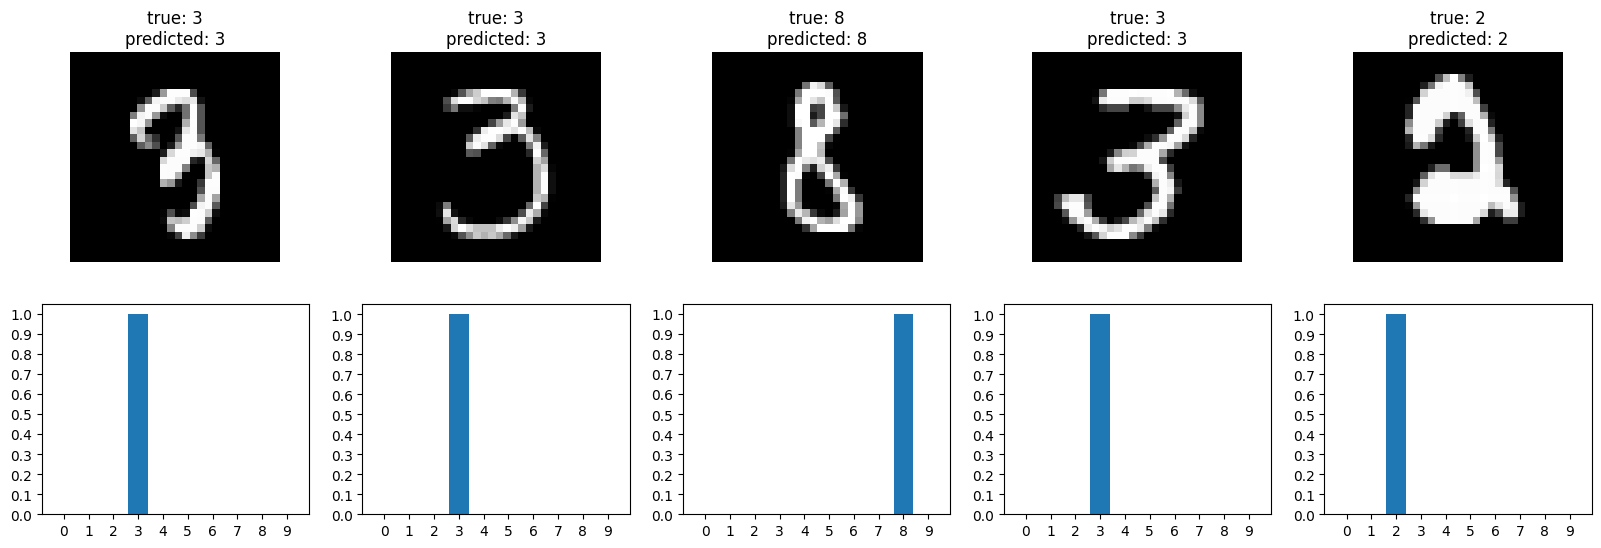

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_mnist(model, loader, num_images = 5):
    random_choices = np.random.randint(1, 10000, size=num_images)

    images_list = []
    labels_list = []
    predictions_list = []
    probability_distributions_list = []

    model.eval()
    with torch.no_grad():
        for choice in random_choices:
            X, y = loader.dataset[choice]
            X = X.reshape(-1, 784).to('cuda:0')

            logits = model(X)

            _, pred = torch.max(logits, 1)
            predictions_list.append(pred.item())

            probability_distributions_list.append(torch.softmax(logits, 1))

            images_list.append(X.cpu())
            labels_list.append(y)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    for i in range(num_images):
        axes[0, i].imshow(images_list[i].reshape(28,28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'true: {labels_list[i]}\npredicted: {predictions_list[i]}')
        axes[1, i].bar(x=np.arange(10), height=probability_distributions_list[i].cpu().numpy().squeeze())
        axes[1, i].set_xticks(np.arange(10))
        axes[1, i].set_yticks(np.linspace(0.0, 1, 11))

    model.train()
    plt.show()
visualize_mnist(net, testing_loader)

In [16]:
#save the model

torch.save(net, 'trained_model.pth')